# ICU Multimodal Patient Monitoring: Static PID vs Temporal Directed Information

In [ ]:
import math
from sklearn.metrics import mutual_info_score

# Binary flags for HR, BP, and event from the scenario table
HR_flag = [1, 0, 1, 0]    # 1=HR high, 0=normal
BP_flag = [1, 1, 0, 0]    # 1=BP low, 0=normal
Event   = [1, 0, 0, 0]    # 1=shock event, 0=no event

# Mutual information (in bits) for single modalities and joint:
I_hr_y  = mutual_info_score(HR_flag, Event) / math.log(2)      # I(HR; Y)
I_bp_y  = mutual_info_score(BP_flag, Event) / math.log(2)      # I(BP; Y)
joint_state = [f"{h}{b}" for h,b in zip(HR_flag, BP_flag)]     # joint state of (HR,BP)
I_hrbp_y = mutual_info_score(joint_state, Event) / math.log(2) # I([HR,BP]; Y)

# PID decomposition (Williams & Beer 2010 using I_min redundancy)
I_red   = min(I_hr_y, I_bp_y)                        # redundant info
U_hr    = I_hr_y - I_red                             # HR unique info
U_bp    = I_bp_y - I_red                             # BP unique info
S       = I_hrbp_y - I_hr_y - I_bp_y + I_red         # synergistic info

print(f"I(HR;Y) = {I_hr_y:.3f} bits, I(BP;Y) = {I_bp_y:.3f} bits")
print(f"I(HR,BP;Y) = {I_hrbp_y:.3f} bits")
print(f"Redundancy = {I_red:.3f}, Unique(HR) = {U_hr:.3f}, Unique(BP) = {U_bp:.3f}, Synergy = {S:.3f}")

I(HR;Y) = 0.311 bits, I(BP;Y) = 0.311 bits
I(HR,BP;Y) = 0.811 bits
Redundancy = 0.311, Unique(HR) = 0.000, Unique(BP) = 0.000, Synergy = 0.500


In [4]:
# Simulated timeline (simplified): 0=normal, 1=anomalous
HR_flag_seq = [0, 0, 0, 0,  # baseline normal
               0,          # t=4: BP drop starts (will reflect in BP_flag_seq)
               0,          # HR normal until BP drops
               0,          # 
               0]          # (extend as needed)
BP_flag_seq = [0, 0, 0, 0, 
               1,          # t=4: BP_flag goes low (BP drop)
               1,          # t=5: BP still low
               1,          # t=6: BP low...
               0]          # recovery

# At t=5, HR responds to prior BP drop:
HR_flag_seq[5] = 1          # t=5: HR_flag goes high in response to BP low at t=4

# Calculate transfer entropy TE(BP -> HR)
import math
from collections import Counter
triples = Counter()
for t in range(1, len(HR_flag_seq)):
    triples[(BP_flag_seq[t-1], HR_flag_seq[t-1], HR_flag_seq[t])] += 1

# Compute joint and conditional probabilities
total = sum(triples.values())
TE_bp_to_hr = 0.0
# Sum_{bp_prev, hr_prev, hr_curr} P(bp_prev, hr_prev, hr_curr) * log2[ P(hr_curr | bp_prev, hr_prev) / P(hr_curr | hr_prev) ]
# (We derive conditional probabilities from frequency counts)
from collections import defaultdict
cond_counts = defaultdict(lambda: defaultdict(int))
cond_counts_hr = defaultdict(lambda: defaultdict(int))
for (bp_prev, hr_prev, hr_curr), count in triples.items():
    cond_counts[(hr_prev, bp_prev)][hr_curr] += count
    cond_counts_hr[hr_prev][hr_curr] += count

for (hr_prev, bp_prev), outcomes in cond_counts.items():
    for hr_curr, count in outcomes.items():
        p_joint = count / total
        p_hr_given_hr_bp = count / sum(outcomes.values())
        p_hr_given_hr = count / sum(cond_counts_hr[hr_prev].values())
        TE_bp_to_hr += p_joint * math.log2(p_hr_given_hr_bp / p_hr_given_hr)

print("DI (BP->HR) =", TE_bp_to_hr, "bits")



# Calculate transfer entropy TE(HR -> BP)
triples_hr_to_bp = Counter()
for t in range(1, len(BP_flag_seq)):
    triples_hr_to_bp[(HR_flag_seq[t-1], BP_flag_seq[t-1], BP_flag_seq[t])] += 1

# Compute joint and conditional probabilities
total_hr_to_bp = sum(triples_hr_to_bp.values())
TE_hr_to_bp = 0.0
# Sum_{hr_prev, bp_prev, bp_curr} P(hr_prev, bp_prev, bp_curr) * log2[ P(bp_curr | hr_prev, bp_prev) / P(bp_curr | bp_prev) ]
cond_counts_hr_to_bp = defaultdict(lambda: defaultdict(int))
cond_counts_bp = defaultdict(lambda: defaultdict(int))
for (hr_prev, bp_prev, bp_curr), count in triples_hr_to_bp.items():
    cond_counts_hr_to_bp[(bp_prev, hr_prev)][bp_curr] += count
    cond_counts_bp[bp_prev][bp_curr] += count

for (bp_prev, hr_prev), outcomes in cond_counts_hr_to_bp.items():
    for bp_curr, count in outcomes.items():
        p_joint = count / total_hr_to_bp
        p_bp_given_bp_hr = count / sum(outcomes.values())
        p_bp_given_bp = cond_counts_bp[bp_prev][bp_curr] / sum(cond_counts_bp[bp_prev].values())
        if p_bp_given_bp > 0:  # Avoid division by zero or log(0)
            TE_hr_to_bp += p_joint * math.log2(p_bp_given_bp_hr / p_bp_given_bp)

print("DI (HR->BP) =", TE_hr_to_bp, "bits")

# Compare the directionality of information flow
print(f"Directionality ratio (BP->HR)/(HR->BP) = {TE_bp_to_hr/TE_hr_to_bp if TE_hr_to_bp > 0 else 'infinite'}")


DI (BP->HR) = 0.7871107149038481 bits
DI (HR->BP) = 0.10784107173763835 bits
Directionality ratio (BP->HR)/(HR->BP) = 7.298802786555887


# Temporal RUS Framework on Multivariate Time Series

In [1]:
import numpy as np
import cvxpy as cp
from scipy.special import rel_entr
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import os

## Compute Transfer Entropy (TE) as Directed Information Quantities
Use binning procedure to discretize continuous data; or use KSG estimator to directly estimate TE in continuous setting (not tested yet).

In [2]:
def estimate_transfer_entropy(source, target, lag=1, bins=10, method='binned'):

    if len(source) != len(target):
        raise ValueError("Source and target must have the same length")
        
    # Create lagged variables
    source_past = source[:-lag]
    target_past = target[:-lag]
    target_present = target[lag:]
    
    if method == 'binned':
        # Discretize data if continuous
        if not np.array_equal(source, source.astype(int)) or not np.array_equal(target, target.astype(int)):
            # Discretize continuous data using digitize instead of histogram
            source_bins = np.linspace(min(source_past), max(source_past), bins+1)
            target_bins = np.linspace(min(target), max(target), bins+1)
            
            source_past_disc = np.digitize(source_past, source_bins)
            target_past_disc = np.digitize(target_past, target_bins)
            target_present_disc = np.digitize(target_present, target_bins)
        else:
            # if already discrete..
            source_past_disc = source_past
            target_past_disc = target_past
            target_present_disc = target_present
        
        # Create joint variable by encoding the joint state as a single integer
        joint_past_disc = source_past_disc * bins + target_past_disc
        
        # Calculate I(target_present; source_past, target_past)
        mi_joint = mutual_info_score(joint_past_disc, target_present_disc) / np.log(2)  # Convert to bits
        
        # Calculate I(target_present; target_past)
        mi_target_past = mutual_info_score(target_past_disc, target_present_disc) / np.log(2)  # Convert to bits
        
        # Transfer entropy
        te = mi_joint - mi_target_past
        return max(0, te)  # Ensure non-negative
    
    elif method == 'ksg':
        # KSG estimator requires additional libraries
        try:
            import jpype
            import pyinfo
            
            if not jpype.isJVMStarted():
                jpype.startJVM(pyinfo.getDefaultJVMPath(), "-ea")
                
            # Calculate TE using JIDT
            from jpype import javax, java
            from jpype import JPackage
            
            teCalcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
            teCalc = teCalcClass()
            teCalc.setProperty("k", "4")  # Use 4 nearest neighbors
            teCalc.initialise(lag)
            teCalc.setObservations(java.lang.reflect.Array.newInstance(java.lang.Double.TYPE, len(source_past)), 
                                  java.lang.reflect.Array.newInstance(java.lang.Double.TYPE, len(target_past)))
            te = teCalc.computeAverageLocalOfObservations()
            
            return te
            
        except ImportError:
            print("KSG estimator requires jpype and JIDT. Falling back to binned estimator.")
            return estimate_transfer_entropy(source, target, lag, bins, method='binned')
    else:
        raise ValueError("Method must be 'binned' or 'ksg'")

## Generate probability distribution P given raw input data for further PID computartion

In [3]:
def create_probability_distribution(X1, X2, Y, lag=1, bins=10):

    X1_past = X1[:-lag]
    X2_past = X2[:-lag]
    Y_present = Y[lag:]
    
    # Discretize continuous data if needed
    if not np.array_equal(X1_past, X1_past.astype(int)) or not np.array_equal(X2_past, X2_past.astype(int)) or not np.array_equal(Y_present, Y_present.astype(int)):
        # Get bin edges
        x1_edges = np.linspace(min(X1_past), max(X1_past), bins+1)
        x2_edges = np.linspace(min(X2_past), max(X2_past), bins+1)
        y_edges = np.linspace(min(Y_present), max(Y_present), bins+1)
        
        # Discretize
        x1_bins = np.digitize(X1_past, x1_edges) - 1
        x2_bins = np.digitize(X2_past, x2_edges) - 1
        y_bins = np.digitize(Y_present, y_edges) - 1
        
        # Ensure values are within bins range
        x1_bins = np.clip(x1_bins, 0, bins-1)
        x2_bins = np.clip(x2_bins, 0, bins-1)
        y_bins = np.clip(y_bins, 0, bins-1)
    else:
        # Already discrete
        x1_bins = X1_past
        x2_bins = X2_past
        y_bins = Y_present
        
        # Get unique values
        x1_unique = np.unique(x1_bins)
        x2_unique = np.unique(x2_bins)
        y_unique = np.unique(y_bins)
        
        # Remap to contiguous integers
        x1_map = {val: i for i, val in enumerate(x1_unique)}
        x2_map = {val: i for i, val in enumerate(x2_unique)}
        y_map = {val: i for i, val in enumerate(y_unique)}
        
        x1_bins = np.array([x1_map[val] for val in x1_bins])
        x2_bins = np.array([x2_map[val] for val in x2_bins])
        y_bins = np.array([y_map[val] for val in y_bins])
        
        bins = max(len(x1_unique), len(x2_unique), len(y_unique))
    
    P = np.zeros((bins, bins, bins))
    for i in range(len(x1_bins)):
        P[x1_bins[i], x2_bins[i], y_bins[i]] += 1
    
    P = P / np.sum(P)
    
    return P

## Solve the optimal Q in temporal & coninuous setting, modified the optimizer a bit.

In [4]:
def solve_Q_temporal(P: np.ndarray):

    # Compute marginals
    Py = P.sum(axis=0).sum(axis=0)
    Px1 = P.sum(axis=1).sum(axis=1)
    Px2 = P.sum(axis=0).sum(axis=1)
    Px2y = P.sum(axis=0)
    Px1y = P.sum(axis=1)
    
    # Define optimization variables
    Q = [cp.Variable((P.shape[0], P.shape[1]), nonneg=True) for i in range(P.shape[2])]
    Q_x1x2 = [cp.Variable((P.shape[0], P.shape[1]), nonneg=True) for i in range(P.shape[2])]

    # Constraints that conditional distributions sum to 1
    sum_to_one_Q = cp.sum([cp.sum(q) for q in Q]) == 1

    # [A]: p(x1, y) == q(x1, y) constraints
    A_cstrs = []
    for x1 in range(P.shape[0]):
        for y in range(P.shape[2]):
            vars = []
            for x2 in range(P.shape[1]):
                vars.append(Q[y][x1, x2])
            A_cstrs.append(cp.sum(vars) == Px1y[x1,y])
    
    # [B]: p(x2, y) == q(x2, y) constraints
    B_cstrs = []
    for x2 in range(P.shape[1]):
        for y in range(P.shape[2]):
            vars = []
            for x1 in range(P.shape[0]):
                vars.append(Q[y][x1, x2])
            B_cstrs.append(cp.sum(vars) == Px2y[x2,y])

    # KL divergence - Product distribution constraints
    Q_pdt_dist_cstrs = [cp.sum(Q) / P.shape[2] == Q_x1x2[i] for i in range(P.shape[2])]

    # Objective: minimize I(X1; X2 | Y)
    obj = cp.sum([cp.sum(cp.rel_entr(Q[i], Q_x1x2[i])) for i in range(P.shape[2])])
    all_constrs = [sum_to_one_Q] + A_cstrs + B_cstrs + Q_pdt_dist_cstrs
    prob = cp.Problem(cp.Minimize(obj), all_constrs)
    
    # Solve with better error handling
    try:
        prob.solve(verbose=False, max_iter=50000)
        if prob.status not in ["optimal", "optimal_inaccurate"]:
            print(f"Warning: Problem status is {prob.status}")
    except Exception as e:
        print(f"Optimization error: {e}")
        # Try with different solver
        try:
            prob.solve(verbose=False, max_iter=50000, solver=cp.ECOS)
        except:
            print("Falling back to SCS solver")
            prob.solve(verbose=False, max_iter=50000, solver=cp.SCS)

    # Convert to numpy array
    return np.stack([q.value for q in Q], axis=2)

## Compute RUS quantities, didn't change this much.

In [5]:
def MI(P: np.ndarray):

    margin_1 = P.sum(axis=1)
    margin_2 = P.sum(axis=0)
    outer = np.outer(margin_1, margin_2)
    
    # Calculate KL divergence
    return np.sum(rel_entr(P, outer))

def CoI_temporal(P: np.ndarray):

    # MI(Y; X1)
    A = P.sum(axis=1)

    # MI(Y; X2)
    B = P.sum(axis=0)

    # MI(Y; (X1, X2))
    C = P.transpose([2, 0, 1]).reshape((P.shape[2], P.shape[0]*P.shape[1]))
    
    # I(Y; X1; X2)
    return MI(A) + MI(B) - MI(C)

def UI_temporal(P, cond_id=0):

    sum_val = 0.0

    if cond_id == 0:
        # Unique info from X2 (condition on X1)
        J = P.sum(axis=(1, 2))  # marginal of X1
        for i in range(P.shape[0]):
            P_slice = P[i,:,:]
            if np.sum(P_slice) > 0:  # Avoid division by zero
                sum_val += MI(P_slice/np.sum(P_slice)) * J[i]
    elif cond_id == 1:
        # Unique info from X1 (condition on X2)
        J = P.sum(axis=(0, 2))  # marginal of X2
        for i in range(P.shape[1]):
            P_slice = P[:,i,:]
            if np.sum(P_slice) > 0:  # Avoid division by zero
                sum_val += MI(P_slice/np.sum(P_slice)) * J[i]
    else:
        raise ValueError("cond_id must be 0 or 1")

    return sum_val

def CI_temporal(P, Q):

    # Ensure P and Q have the same shape
    assert P.shape == Q.shape
    
    # Reshape to 2D for mutual information calculation
    P_ = P.transpose([2, 0, 1]).reshape((P.shape[2], P.shape[0]*P.shape[1]))
    Q_ = Q.transpose([2, 0, 1]).reshape((Q.shape[2], Q.shape[0]*Q.shape[1]))
    
    # Calculate total MI in P minus total MI in Q (synergy)
    return MI(P_) - MI(Q_)

def temporal_pid(X1, X2, Y, lag=1, bins=10):

    # Create joint probability distribution
    P = create_probability_distribution(X1, X2, Y, lag, bins)
    
    # Optimize to get Q (distribution with minimal synergy)
    Q = solve_Q_temporal(P)
    
    # Calculate PID components
    redundancy = CoI_temporal(Q)
    unique_x1 = UI_temporal(Q, cond_id=1)
    unique_x2 = UI_temporal(Q, cond_id=0)
    synergy = CI_temporal(P, Q)
    
    # Calculate total directed information (should equal sum of components)
    total_di = MI(P.transpose([2, 0, 1]).reshape((P.shape[2], P.shape[0]*P.shape[1])))
    
    # Create results dictionary
    results = {
        'redundancy': redundancy,
        'unique_x1': unique_x1,
        'unique_x2': unique_x2,
        'synergy': synergy,
        'total_di': total_di,
        'sum_components': redundancy + unique_x1 + unique_x2 + synergy
    }
    
    return results

def multi_lag_analysis(X1, X2, Y, max_lag=5, bins=10):

    results = {
        'lag': [],
        'redundancy': [],
        'unique_x1': [],
        'unique_x2': [],
        'synergy': [],
        'total_di': []
    }
    
    for lag in range(1, max_lag + 1):
        print(f"Analyzing lag {lag}...")
        pid_result = temporal_pid(X1, X2, Y, lag, bins)
        
        results['lag'].append(lag)
        results['redundancy'].append(pid_result['redundancy'])
        results['unique_x1'].append(pid_result['unique_x1'])
        results['unique_x2'].append(pid_result['unique_x2'])
        results['synergy'].append(pid_result['synergy'])
        results['total_di'].append(pid_result['total_di'])
    
    return results

## Plot Functions

In [6]:
def plot_multi_lag_results(results, save_path=None):

    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(results['lag'], results['total_di'], 'ko-', linewidth=2, label='Total DI')
    plt.plot(results['lag'], results['redundancy'], 'b.-', label='Redundancy')
    plt.plot(results['lag'], results['unique_x1'], 'g.-', label='Unique X1')
    plt.plot(results['lag'], results['unique_x2'], 'r.-', label='Unique X2')
    plt.plot(results['lag'], results['synergy'], 'm.-', label='Synergy')
    plt.xlabel('Time Lag', fontsize=20)
    plt.ylabel('Information (bits)', fontsize=20)
    plt.title('PID Components vs Time Lag', fontsize=24)
    plt.legend(fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Stacked area plot
    plt.subplot(2, 1, 2)
    plt.stackplot(
        results['lag'], 
        [results['redundancy'], results['unique_x1'], results['unique_x2'], results['synergy']],
        labels=['Redundancy', 'Unique X1', 'Unique X2', 'Synergy'],
        colors=['blue', 'green', 'red', 'magenta'],
        alpha=0.7
    )
    plt.plot(results['lag'], results['total_di'], 'k--', linewidth=2, label='Total DI')
    plt.xlabel('Time Lag', fontsize=20)
    plt.ylabel('Information (bits)', fontsize=20)
    plt.title('Stacked PID Components', fontsize=24)
    plt.legend(fontsize=16)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()


def compare_mi_di(X1, X2, Y, max_lag=5, bins=10, save_path=None):

    # Calculate mutual information (static)
    mi_x1y = mutual_info_score(
        np.digitize(X1, np.linspace(min(X1), max(X1), bins+1)),
        np.digitize(Y, np.linspace(min(Y), max(Y), bins+1))
    ) / np.log(2)
    
    mi_x2y = mutual_info_score(
        np.digitize(X2, np.linspace(min(X2), max(X2), bins+1)),
        np.digitize(Y, np.linspace(min(Y), max(Y), bins+1))
    ) / np.log(2)
    
    # Calculate directed information for different lags
    di_x1y = np.zeros(max_lag+1)
    di_x2y = np.zeros(max_lag+1)
    
    for lag in range(1, max_lag+1):
        di_x1y[lag] = estimate_transfer_entropy(X1, Y, lag, bins)
        di_x2y[lag] = estimate_transfer_entropy(X2, Y, lag, bins)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # MI comparison
    plt.subplot(1, 2, 1)
    plt.bar(['X1→Y', 'X2→Y'], [mi_x1y, mi_x2y], color=['blue', 'orange'])
    plt.title('Mutual Information (Static)', fontsize=24)
    plt.ylabel('Information (bits)', fontsize=20)
    
    # DI comparison
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_lag+1), di_x1y[1:], 'bo-', label='X1→Y')
    plt.plot(range(1, max_lag+1), di_x2y[1:], 'ro-', label='X2→Y')
    plt.title('Directed Information (Transfer Entropy)', fontsize=24)
    plt.xlabel('Time Lag', fontsize=20)
    plt.ylabel('Information (bits)', fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()
    
    # Create comparison dictionary
    comparison = {
        'mi_x1y': mi_x1y,
        'mi_x2y': mi_x2y,
        'di_x1y': di_x1y[1:],
        'di_x2y': di_x2y[1:],
    }
    
    return comparison

## Data generating function: two-variable time series

In [7]:
def generate_causal_time_series(n_samples=1000, causal_strength=0.7, noise_level=0.1, seed=None):

    if seed is not None:
        np.random.seed(seed)
    
    # Generate independent sources
    X1 = np.random.randn(n_samples)
    X2 = np.random.randn(n_samples)
    
    # Generate target with causal influence from X1 (lag 1) and X2 (lag 2)
    Y = np.zeros(n_samples)
    
    for t in range(n_samples):
        if t >= 1:
            # Influence from X1 with lag 1
            Y[t] += causal_strength * X1[t-1]
        if t >= 2:
            # Influence from X2 with lag 2
            Y[t] += causal_strength * X2[t-2]
        
        # Add noise
        Y[t] += noise_level * np.random.randn()
    
    return X1, X2, Y

Generating synthetic time series data...
Comparing mutual information and directed information...


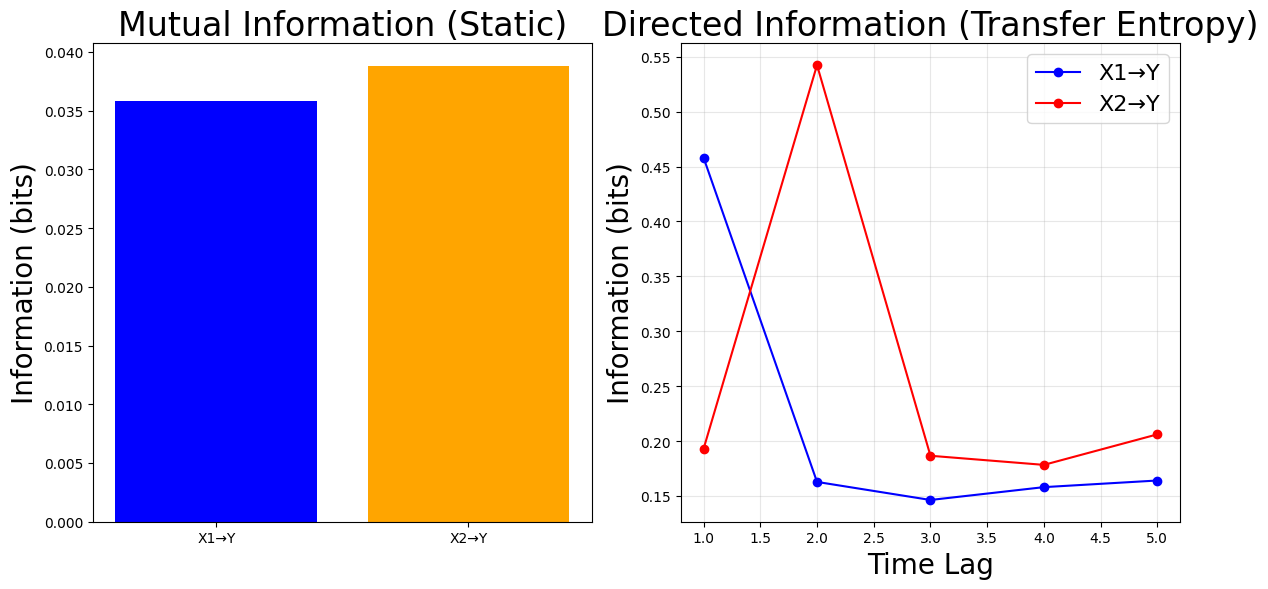

Performing multi-lag PID analysis...
Analyzing lag 1...
Analyzing lag 2...
Analyzing lag 3...
Analyzing lag 4...
Analyzing lag 5...
Plotting PID results...


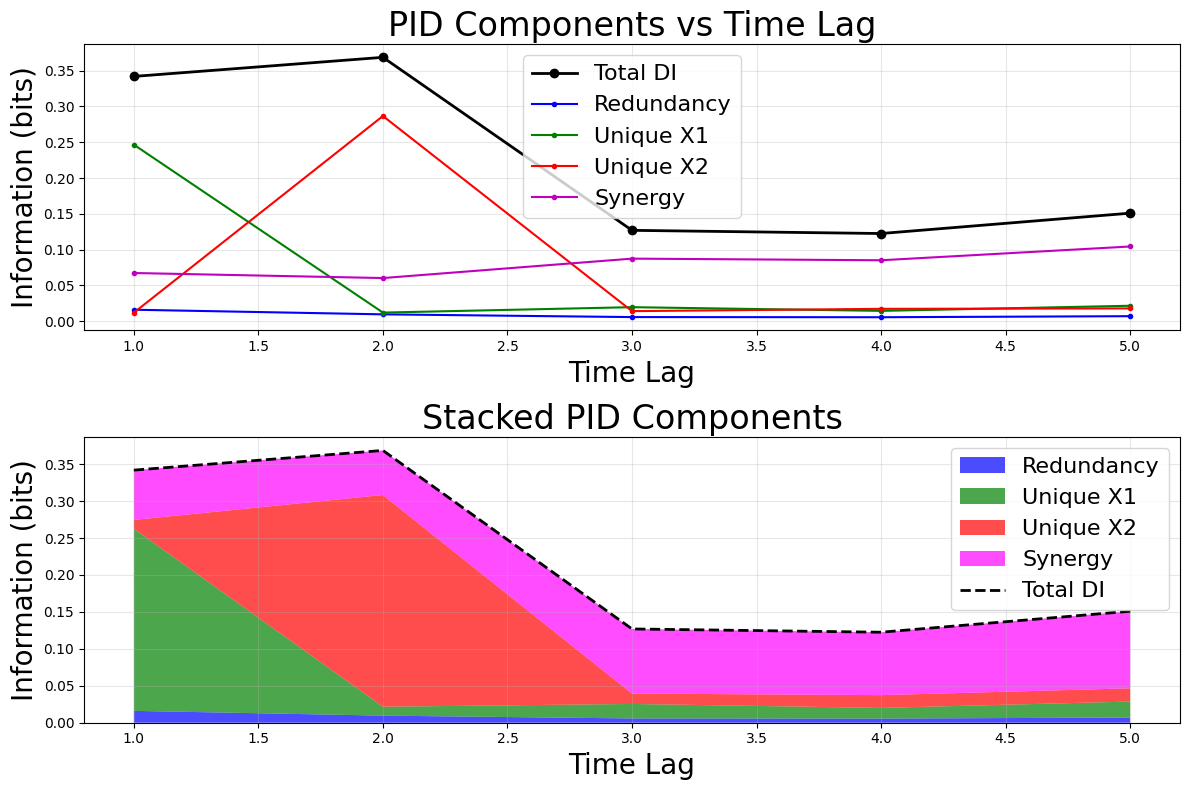

In [8]:
print("Generating synthetic time series data...")
X1, X2, Y = generate_causal_time_series(n_samples=1000, causal_strength=0.7, noise_level=0.2, seed=42)

print("Comparing mutual information and directed information...")
# Create results directory if it doesn't exist
if not os.path.exists('../results'):
    os.makedirs('../results')
    
compare_mi_di(X1, X2, Y, max_lag=5, bins=8)

print("Performing multi-lag PID analysis...")
results = multi_lag_analysis(X1, X2, Y, max_lag=5, bins=8)

print("Plotting PID results...")
plot_multi_lag_results(results)